# LIM forecasting: multivariate separate sic each month

Katie Brennan  
started March 2021  
  
#### Goals: 
* Build a LIM based on SIC 
* Build a LIM based on both SIC and SIT 
* Compare performance

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [2]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb

In [3]:
sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [4]:
import importlib
importlib.reload(limkb)

<module 'LIM_utils_kb' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils_kb.py'>

In [5]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [6]:
# number of EOFs to retain for the LIM state vector
ntrunc = 400 # EOF truncation for individual fields (reduced-state space)
nmodes = 60 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

mo=1

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 0.60

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
limvars = ['tas','tos','sic']
limvars_nosic = ['tas','tos']

nvars = len(limvars)

# specify the model source 
train_dsource = 'mpi_lm_kb'
#train_dsource = 'ccsm4_lm_kb'
valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True

In [7]:
full_names = {'tas':'Surface air temperature',
              'psl':'Sea level Pressure',
              'sic':'Sea ice concentration', 
              'sit':'Sea ice thickness',
              'tos':'Sea surface temperature',
              'zg': '500hPa geopotential height'}

areawt_name = {'tas':'areacella',
               'psl':'areacella',
               'sic':'areacello', 
               'sit':'areacello',
               'tos':'areacello',
               'zg': 'areacella'}

month_names = ['January','Februrary','March','April','May','June','July','August',
               'September','October','November','December']

In [8]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_ccsm4 = limkb.build_training_dic(train_dsource)
fdic_mpi = limkb.build_training_dic(valid_dsource)

In [11]:
areacell = {}
areacella_dict = {}
areacell['areacella'], areacella_dict = limkb.load_data('areacella', areacella_dict, fdic_ccsm4, 
                                                  remove_climo=False, detrend=False, verbose=False)

areacello_dict = {}
areacell['areacello'], areacello_dict = limkb.load_data('areacello', areacello_dict, fdic_ccsm4, 
                                                  remove_climo=False, detrend=False, verbose=False)

areacell_dict = {}
areacell_dict['areacello'] = areacello_dict
areacell_dict['areacella'] = areacella_dict

43238625000.0
1119424500.0
43238625000.0
1119424500.0
34075988000.0
162433550.0
34075988000.0
162433550.0


## Build L from scratch: 

In [12]:
# load training data...
mo = 1

wt=True
var_dict = {}
tot_var = {}
tot_var_eig = {}
W_all = {}
E3 = {}
Ptrunc = {}
standard_factor = {}

tot_var_valid = {}
tot_var_eig_valid = {}
W_all_valid = {}
E3_valid = {}
Ptrunc_valid = {}
standard_factor_valid = {}

n=0

for k, var in enumerate(limvars): 
    X_var, var_dict = limkb.load_data(var, var_dict, fdic_ccsm4, remove_climo=False, 
                                      detrend=True, verbose=True)
    
    tsamp = X_var.shape[1]
    nyears_train = int((tsamp*ntrain)/12)
    #nyears_valid = int(X_all_mpi.shape[2]/12)
    nyears_valid = int((tsamp*(1-ntrain))/12)

    X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
    X_train = X_t[:,0:nyears_train,mo:mo+2]
    X_train_mn = np.nanmean(X_train,axis=1)
    X_train_anom = X_train - X_train_mn[:,np.newaxis,:]
    X_train_2d = np.reshape(X_train_anom,(X_train_anom.shape[0],nyears_train*2))
    
    X_valid = X_t[:,nyears_train:,mo]
    X_valid_mn = np.nanmean(X_valid,axis=1)
    X_valid_anom = X_valid - X_valid_mn[:,np.newaxis]
#    truth = X_t[:,nyears_train:,mo+1]
    ntime = X_train.shape[1]
     
    [Ptrunc[var], E3[var], tot_var[var],tot_var_eig[var], W_all[var], 
     standard_factor[var]] = limkb.step1_compress_individual_var(X_train_2d, var, ntrunc, nmodes_sic, var_dict, 
                                                                 n, reawt=areacell[areawt_name[var]],
                                                                 wt=wt, sic_separate=sic_separate)
    
    [Ptrunc_valid[var], E3_valid[var], tot_var_valid[var],
     tot_var_eig_valid[var],W_all_valid[var],
     standard_factor_valid[var]] = limkb.step1_compress_individual_var(X_valid_anom, var,ntrunc, nmodes_sic, 
                                                                       var_dict, n, 
                                                                       areawt=areacell[areawt_name[var]],
                                                                       wt=wt, sic_separate=sic_separate)
#     for m in range(12):
#         X_valid = X_t[:,nyears_train:,m]
        
#         [Ptrunc_valid, E3_valid, tot_var_valid,
#         tot_var_eig_valid, W_all_valid] = step1_compress_individual_var(X_valid, ntrunc, nmodes_sic, var_dict, n, 
#                                                                         areawt=areacell[areawt_name[var]],
#                                                                         wt=wt, sic_separate=sic_separate)
#         Ptrunc_valid_var[:,:,m] = Ptrunc_valid[var]
#         E3_valid_var[:,:,m] = E3_valid[var]
        
    del X_var

Loading tas
318.38275
196.0311
detrending...
35.779022216796875
-36.74366760253906
-----------------------------------------------------
completed in 19.251534700393677 seconds
-----------------------------------------------------
fraction in first 400 tas EOFs = 96.91354075407581
fraction in first 400 tas EOFs = 100.0
Loading tos
nan
nan
detrending...
nan
nan
-----------------------------------------------------
completed in 73.47764801979065 seconds
-----------------------------------------------------
fraction in first 400 tos EOFs = 95.27070992667088
fraction in first 400 tos EOFs = 100.0
Loading sic
110.87671
0.0
detrending...
98.17611694335938
-95.50435638427734
-----------------------------------------------------
completed in 53.41555690765381 seconds
-----------------------------------------------------
fraction in first 400 sic EOFs = 89.24620612726274
fraction in first 400 sic EOFs = 89.81056209900699


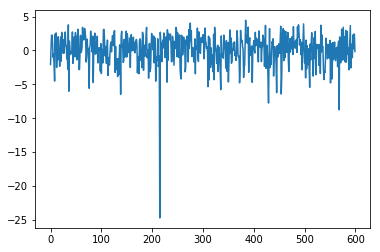

In [21]:
plt.plot(X_train_2d[1061,0:600])

In [13]:
# Get indices for each variable:
start = 0
for k, var in enumerate(limvars): 
    print('working on '+var)
    inds = var_dict[var]['var_ndof']
    var_inds = np.arange(start,start+inds,1)
    start = inds+start
    
    var_dict[var]['var_inds'] = var_inds

working on tas
working on tos
working on sic


In [14]:
ndof_all = limkb.count_ndof_all(limvars, E3, sic_separate=sic_separate)

[Ptrunc_all, E3_all, 
Ptrunc_sic, E_sic] = limkb.stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
                                               var_dict, sic_separate=sic_separate)

[P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, Ptrunc_sic, 
                                                       sic_separate=sic_separate)

Fraction in first 60 multivariate EOFs = 73.30332213653229
Shape of E: (74752, 60)


In [15]:
ndof_all_valid = limkb.count_ndof_all(limvars, E3_valid, sic_separate=sic_separate)

[Ptrunc_all_valid, E3_all_valid,
 Ptrunc_sic_valid, E_sic_valid] = limkb.stack_variable_eofs(limvars, ndof_all_valid, ntrunc, Ptrunc_valid, E3_valid, 
                                                      var_dict, sic_separate=sic_separate)

[P_train_valid, Fvar_valid, 
 E_valid] = limkb.step2_multivariate_compress(Ptrunc_all_valid,nmodes, E3_all_valid, Ptrunc_sic_valid,
                                              sic_separate=sic_separate)

Fraction in first 60 multivariate EOFs = 74.87816205061475
Shape of E: (74752, 60)


In [16]:
nmo = int(P_train.shape[1]/nyears_train)
P_train_3d = np.reshape(P_train, (P_train.shape[0],nyears_train,nmo))

LIMd2, G2 = lim.LIM_train_flex(tau,P_train_3d[:,:,0], P_train_3d[:,:,1])
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [17]:
LIM_save = {}
LIM_save['LIMd2'] = LIMd2
LIM_save['var_dict'] = var_dict
LIM_save['P_train_valid'] = P_train_valid
LIM_save['P_train'] = P_train
LIM_save['E'] = E
LIM_save['E_sic'] = E_sic
LIM_save['E_valid'] = E_valid
LIM_save['E_sic_valid'] = E_sic_valid
LIM_save['W_all'] = W_all
LIM_save['W_all_valid'] = W_all_valid
LIM_save['X_valid_mn'] = X_valid_mn
LIM_save['X_train_mn'] = X_train_mn

var_nms = [l+'_' for l in limvars]
savename = ('L_mo'+str(mo)+'_'+ ''.join(var_nms)+ 'ntrunc'+str(ntrunc)+'_nmodes'+str(nmodes)+
            '_nmodessic'+str(nmodes_sic)+'_031621.pkl')
pickle.dump(LIM_save, open(savename, "wb" ) )

## Load pre-build L: 

In [12]:
var_nms = [l+'_' for l in limvars]
savename = ('L_mo'+str(mo)+'_'+''.join(var_nms)+ 'ntrunc'+str(ntrunc)+
            '_nmodes'+str(nmodes)+'_nmodessic'+str(nmodes_sic)+'_031621.pkl')

LIM_save = pickle.load(open(savename, "rb" ) )

LIMd2 = LIM_save['LIMd2']
var_dict = LIM_save['var_dict']
P_train_valid = LIM_save['P_train_valid'] 
P_train = LIM_save['P_train']
E = LIM_save['E'] 
E_sic = LIM_save['E_sic'] 
E_valid = LIM_save['E_valid']
E_sic_valid = LIM_save['E_sic_valid']
W_all = LIM_save['W_all'] 
W_all_valid = LIM_save['W_all_valid']


In [13]:
# # Open truncated validation data: 
# var_nms = [l+'_' for l in limvars]
# savename = ('P_train_valid_allmo_'+ ''.join(var_nms)+ 'ntrunc'+str(ntrunc)+
#             '_nmodes'+str(nmodes)+'_nmodessic'+str(nmodes_sic)+'_031521.pkl')

# P_save = pickle.load(open(savename, "rb" ) )

# P_train_valid_allmo = P_save['Ptrain_valid_allmo']
# Fvar_valid_allmo = P_save['Fvar_valid_allmo']
# E_valid_allmo = P_save['E_valid_allmo'] 

## Run Forecast: 

In [14]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
#lags = [0,1,2,3,4,5,6,7,8,9,10,11]
lags = [0,1,2,3]
#lags = [1]
#lags = [0,3,6,12]
ntims = len(lags)

LIM_fcast = limkb.LIM_forecast_Gt(LIMd2,P_train_valid,lags)
#LIM_fcast = LIM_forecast_Gt(LIMd2,P_train_valid,lags)

t= 0
t= 1
t= 2
t= 3


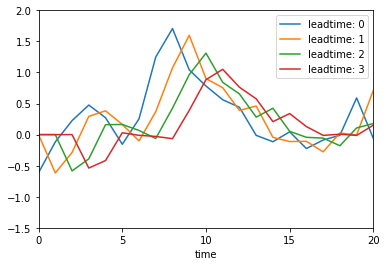

In [15]:
plt.plot(LIM_fcast['x_forecast'][0,0,:], label='leadtime: 0')
plt.plot(LIM_fcast['x_forecast'][1,0,:], label='leadtime: 1')
plt.plot(LIM_fcast['x_forecast'][2,0,:], label='leadtime: 2')
plt.plot(LIM_fcast['x_forecast'][3,0,:], label='leadtime: 3')
# plt.plot(LIM_fcast['x_forecast'][4,0,:])
#plt.plot(LIM_fcast['x_forecast'][10,0,:])
plt.xlim(0,20)
plt.xticks(np.arange(0,400,5))
plt.xlim(0,20)
plt.ylim(-1.5,2.0)
plt.xlabel('time')
plt.xlabel('time')
plt.legend()

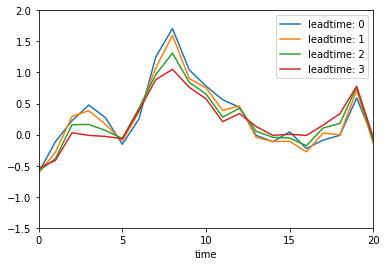

In [16]:
plt.plot(np.arange(0,400,1),LIM_fcast['x_forecast'][0,0,:], label='leadtime: 0')
plt.plot(np.arange(0,399,1),LIM_fcast['x_forecast'][1,0,1:], label='leadtime: 1')
plt.plot(np.arange(0,398,1),LIM_fcast['x_forecast'][2,0,2:], label='leadtime: 2')
plt.plot(np.arange(0,397,1),LIM_fcast['x_forecast'][3,0,3:], label='leadtime: 3')
# plt.plot(LIM_fcast['x_forecast'][4,0,:])
#plt.plot(LIM_fcast['x_forecast'][10,0,:])
plt.xlim(0,20)
plt.xticks(np.arange(0,400,5))
plt.xlim(0,20)
plt.ylim(-1.5,2.0)
plt.xlabel('time')
plt.xlabel('time')
plt.legend()

In [17]:
x_forecast_dcomp = np.zeros((LIM_fcast['x_forecast'].shape[0],E.shape[0]+E_sic.shape[0],
                             LIM_fcast['x_forecast'].shape[2]))

for i,lag in enumerate(lags):
    print('Lag '+ str(lag))
    x_forecast_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(LIM_fcast['x_forecast'][i,:,:],
                                                           nmodes,nmodes_sic,E_valid,
                                                           E_sic,limvars,var_dict,
                                                           W_all_valid,sic_separate=sic_separate)
    
#units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']                                                           W_all,Weights=True,sic_separate=sic_separate)

Lag 0
Lag 1
Lag 2
Lag 3


(0, 100)

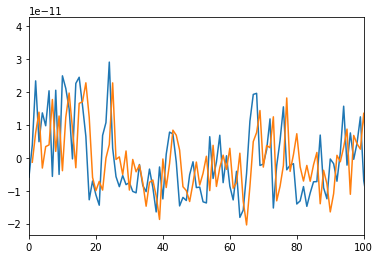

In [18]:
x_test = x_forecast_dcomp[0,var_dict['sic']['var_inds'],:]
x_test1 = x_forecast_dcomp[1,var_dict['sic']['var_inds'],:]

plt.plot(np.arange(0,400,1),x_test[0,:])
plt.plot(np.arange(1,400,1),x_test1[0,1:])
#plt.plot(np.arange(5,400,1),x_test1[0,5:])
plt.xlim(0,100)

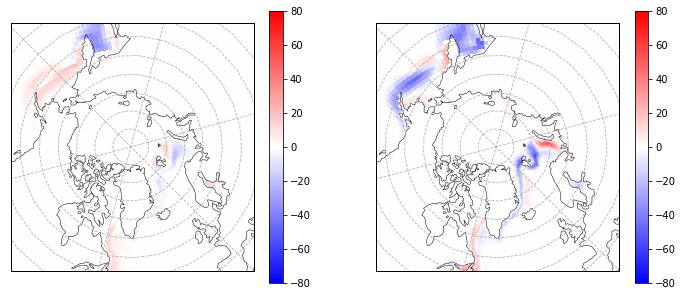

In [56]:
var = 'sic'
x_reshape = np.reshape(x_forecast_dcomp[1,var_dict[var]['var_inds'],:], (220,256,400))
x_reshape2 = np.reshape(x_forecast_dcomp[0,var_dict[var]['var_inds'],:], (220,256,400))

fig,ax = plt.subplots(1,2,figsize=(12,5), subplot_kw=arc_proj )
ax = ax.flatten()

plotkb.sub_arctic_plot(ax[0],fig,x_reshape[:,:,20],var_dict[var]['lat'],var_dict[var]['lon'],
                maxv=80,minv=-80,cmap='bwr')
plotkb.sub_arctic_plot(ax[1],fig,x_reshape2[:,:,20],var_dict[var]['lat'],var_dict[var]['lon'],
                maxv=80,minv=-80,cmap='bwr')


In [22]:
validvars = ['sic']
validation_stats = {}
valid_stats = {}
v = {}

for k, var in enumerate(validvars): 
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))

#    X_var, _ = limkb.load_data(var, v, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    mo = 1
    for i,lag in enumerate(lags):
        print('Lag '+str(lag))
        
        tsamp = X_var.shape[1]
        nyears_train = int((tsamp*ntrain)/12)
        nyears_valid = int((tsamp*(1-ntrain))/12)

        X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
        
        step = mo+lag
        if step>11:
            step = step-12
            start_yr = nyears_train+1
        else: 
            start_yr = nyears_train
            
        x_truth = X_t[:,start_yr:,step]
        x_truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]

        x_forecast = x_forecast_dcomp[i,var_dict[var]['var_inds'],:]
        
        if var is 'sic':
            x_forecast_noneg = np.where(x_forecast<-100.0, -100.0, x_forecast)
            x_forecast_new = np.where(x_forecast_noneg>100.0, 100.0, x_forecast_noneg)
        else: 
            x_forecast_new = x_forecast

        units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
        tot_nh_sic_forecast = statskb.calc_tot_si(x_forecast_new, areacell[areawt_name[var]], 
                                          units, var_dict[var]['lat'], lat_cutoff=0.0)
        tot_nh_sic_truth = statskb.calc_tot_si(x_truth_anom, areacell[areawt_name[var]], 
                                       units, var_dict[var]['lat'],lat_cutoff=0.0)
        
        if lag ==0: 
            corr_tot[i] = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
            ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth,tot_nh_sic_forecast)
            
            error_var = np.nanvar(x_forecast_new - x_truth,axis=1,ddof=1)
            truth_error_var = np.nanvar(x_truth,axis=1,ddof=1)
        else: 
            corr_tot[i] = np.corrcoef(tot_nh_sic_truth[:-lag],tot_nh_sic_forecast[lag:])[0,1]
            ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth[:-lag],tot_nh_sic_forecast[lag:])

            error_var = np.nanvar(x_forecast_new[:,lag:] - x_truth[:,:-lag],axis=1,ddof=1)
            truth_error_var = np.nanvar(x_truth[:,:-lag],axis=1,ddof=1)
            
        gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
        gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])
        
        gm_var_ratio[i]=gm_error_var/gm_truth_var
        
    valid_stats['gm_var_ratio'] = gm_var_ratio
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
        
    validation_stats[var] = valid_stats

Loading sic
-----------------------------------------------------
completed in 29.300317764282227 seconds
-----------------------------------------------------
Lag 0
Lag 1
Lag 2
Lag 3


Text(0.5,1,'Error Variance: SIC')

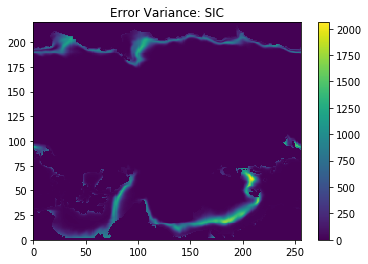

In [24]:
error_sic_2d = np.reshape(error_var, (var_dict['sic']['lat'].shape))
plt.pcolormesh(error_sic_2d)
plt.colorbar()
plt.title('Error Variance: SIC')

Text(0.5,1,'Truth Variance: SIC')

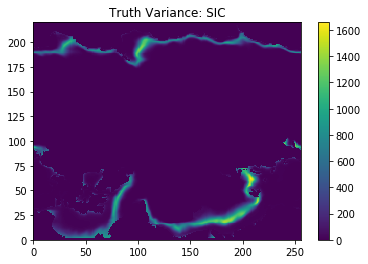

In [25]:
error_sic_2d = np.reshape(truth_error_var, (var_dict['sic']['lat'].shape))
plt.pcolormesh(error_sic_2d)
plt.colorbar()
plt.title('Truth Variance: SIC')

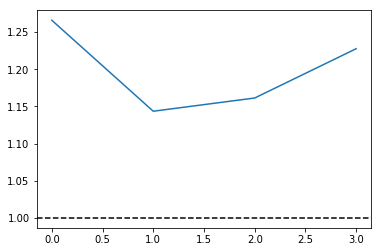

In [27]:
plt.plot(valid_stats['gm_var_ratio'])
plt.axhline(1,linestyle='--', color='k')

Text(0.5,1,'Februrary')

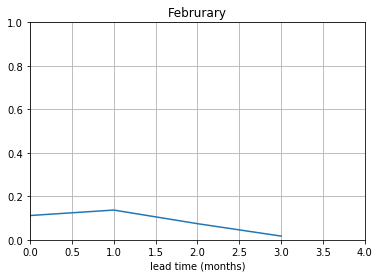

In [29]:
plt.plot(valid_stats['corr_tot']**2, label='Correlation')
plt.plot(valid_stats['ce_tot'],label='CE')
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
plt.xlim(0,4)
plt.grid(axis='both')
plt.xlabel('lead time (months)')
plt.title(month_names[mo])

(0, 50)

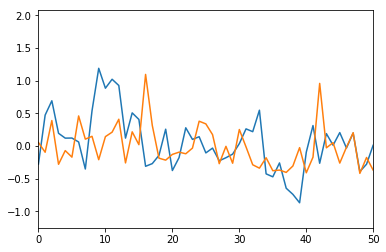

In [35]:
plt.plot(tot_nh_sic_truth*1e-6)
plt.plot((tot_nh_sic_forecast[3:]- np.nanmean(tot_nh_sic_forecast[3:]))*1e-6)
plt.xlim(0,50)

In [62]:
lag=1
i=1
valid_stats_test = {}
v = {}       
        
tsamp = X_var.shape[1]
nyears_train = int((tsamp*ntrain)/12)
nyears_valid = int((tsamp*(1-ntrain))/12)

X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))

step = mo+lag
if step>11:
    step = step-12
    start_yr = nyears_train+1
else: 
    start_yr = nyears_train

x_truth = X_t[:,start_yr:,step]
x_truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]

x_forecast = x_forecast_dcomp[i,var_dict[var]['var_inds'],:]

if var is 'sic':
    x_forecast_noneg = np.where(x_forecast<-100.0, 0, x_forecast)
    x_forecast_new = np.where(x_forecast_noneg>100.0, 100.0, x_forecast_noneg)
else: 
    x_forecast_new = x_forecast

units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
tot_nh_sic_forecast = statskb.calc_tot_si(x_forecast_new, areacell[areawt_name[var]], 
                                  units, var_dict[var]['lat'], lat_cutoff=0.0)
tot_nh_sic_truth = statskb.calc_tot_si(x_truth_anom, areacell[areawt_name[var]], 
                               units, var_dict[var]['lat'],lat_cutoff=0.0)

if lag ==0: 
    corr_tot[i] = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
    ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth,tot_nh_sic_forecast)

    error_var = np.nanvar(x_truth_anom - x_forecast_new,axis=1,ddof=1)
    truth_error_var = np.nanvar(x_truth_anom,axis=1,ddof=1)
else: 
    corr_tot[i] = np.corrcoef(tot_nh_sic_truth[:-lag],tot_nh_sic_forecast[lag:])[0,1]
    ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth[:-lag],tot_nh_sic_forecast[lag:])

    error_var = np.nanvar(x_truth_anom[:,:-lag] - x_forecast_new[:,lag:],axis=1,ddof=1)
    truth_error_var = np.nanvar(x_truth_anom[:,:-lag],axis=1,ddof=1)

gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])

gm_var_ratio[i]=gm_error_var/gm_truth_var

valid_stats_test['gm_var_ratio'] = gm_var_ratio
valid_stats_test['corr_tot'] = corr_tot
valid_stats_test['ce_tot'] = ce_tot

In [70]:
error_var[1060]

5.642948740900908

In [73]:
err[1060].var(), x_truth_anom[1060,:-lag].var()

(5.628806012226972, 5.147571132398257)

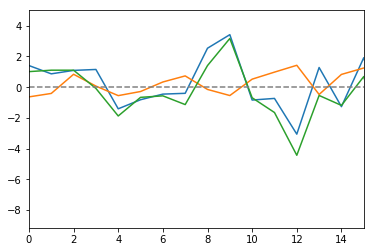

In [85]:
err = (x_truth[:,:] - x_forecast_new[:,:])

plt.plot(x_truth_anom[1060,:-lag])
plt.plot(x_forecast_new[1060,lag:])
plt.plot(err[1060,:])
plt.xlim(0,15)
plt.axhline(0,color='grey',linestyle='--')

In [81]:
x_truth_anom[1060,12], x_forecast_new[1060,12], x_truth_anom[1060,12]-x_forecast_new[1060,12]

(-3.062129030376673, 0.9810918749062055, -4.043220905282879)

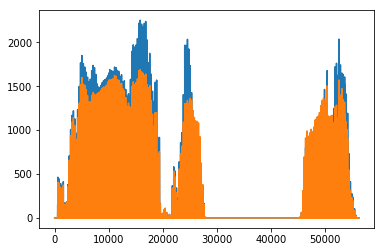

In [41]:
plt.plot((error_var))
plt.plot(truth_error_var)

In [108]:
# validvars = ['sic']
# v = {}

# for k, var in enumerate(validvars): 
#     X_var, _ = load_data(var, v, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    
#     mo = 1
#     tsamp = X_var.shape[1]
#     nyears_train = int((tsamp*ntrain)/12)
#     nyears_valid = int((tsamp*(1-ntrain))/12)

#     X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
#     x_truth = X_t[:,nyears_train:,mo+1]
    
#     x_forecast = x_forecast_dcomp[var_dict[var]['var_inds'],:]
    
#     units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
#     tot_nh_sic_forecast = calc_tot_si(x_forecast, areacell[areawt_name[var]], 
#                                       units, var_dict[var]['lat'], cutoff=0.0)
#     tot_nh_sic_truth = calc_tot_si(x_truth, areacell[areawt_name[var]], 
#                                    units, var_dict[var]['lat'],cutoff=0.0)
    
#     corr_tot_sic = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
#     ce_tot_sic = LMR_utils.coefficient_efficiency(tot_nh_sic_truth,tot_nh_sic_forecast)
    
#     error_var = np.nanvar(x_forecast - x_truth,axis=1,ddof=1)
#     gm_error_var = global_mean(error_var,areacell[areawt_name[var]])
    
#     truth_error_var = np.nanvar(x_truth,axis=1,ddof=1)
#     gm_truth_var = global_mean(truth_error_var,areacell[areawt_name[var]])

Loading sic
-----------------------------------------------------
completed in 86.63140058517456 seconds
-----------------------------------------------------


In [64]:
validation_stats['sic']['gm_var_ratio'].shape, validation_stats['sic']['corr_tot'].shape, validation_stats['sic']['ce_tot'].shape

((12,), (12, 400), (12, 400))

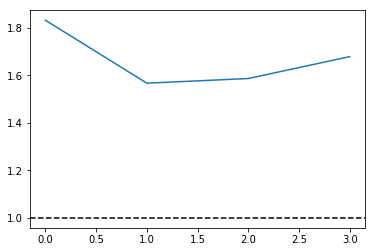

In [51]:
plt.plot(validation_stats['sic']['gm_var_ratio'])
plt.axhline(1,linestyle='--', color='k')

Text(0.5,1,'Februrary')

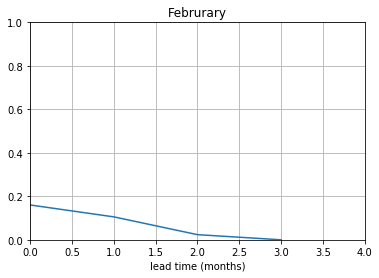

In [52]:
plt.plot(validation_stats['sic']['corr_tot']**2, label='Correlation')
plt.plot(validation_stats['sic']['ce_tot'],label='CE')
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
plt.xlim(0,4)
plt.grid(axis='both')
plt.xlabel('lead time (months)')
plt.title(month_names[mo])

In [54]:
validation_stats['sic']['corr_tot'], validation_stats['sic']['ce_tot']

(array([0.40027682, 0.32482808, 0.153841  , 0.00142255]),
 array([-0.28152417, -0.15181716, -0.48757427, -1.16456038]))

In [51]:
validation_stats['sic'].keys()

dict_keys(['gm_var_ratio', 'corr_tot', 'ce_tot'])

In [57]:
validation_stats['sic']['corr_tot'].shape

(12, 400)

In [ ]:
LIMd['G']**t

In [26]:
def arctic_mean(var, areacell, cutoff=0.0): 
    tot_nh_var = var*areacell
    if len(lat.shape)<=1:
        lat_inds = np.where(var_dict[var]['lat']>cutoff)
        tot_nh_var = np.nansum(np.nansum(tot_nh_var[:,lat_inds,:],axis=1),axis=1)
    
        wt_sum = np.nansum(np.nansum(cellarea[lat_inds,:],axis=0),axis=0)
    else:
        lat_inds = np.where(var_dict[var]['lat']>cutoff)
        tot_nh_var = np.nansum(np.nansum(tot_nh_var[:,lat_inds],axis=1),axis=1)
    
        wt_sum = np.nansum(np.nansum(cellarea[lat_inds],axis=0),axis=0)
    
    var_mn = tot_nh_var/wt_sum
    
    return var_mn

In [27]:
def global_mean(var, areacell): 
    """Assumes var is dimensions (nlat*nlon,time)
    """
    
    tot_nh_var = var*areacell
    
    tot_var = np.nansum(tot_nh_var,axis=0)
    wt_sum = np.nansum(areacell,axis=0)
    
    var_mn = tot_var/wt_sum
    
    return var_mn

In [28]:
def calc_tot_si(var, areacell, units, lat, cutoff=0.0): 
    if units == 'm2':
        cellarea = (areacell*1e-6)[:,np.newaxis]
    else: 
        cellarea = areacell[:,np.newaxis]
        
    if var.max()>2:
        Var = var/100.0
    else: 
        Var = var
        
    nh_var = Var*cellarea
    
    if len(lat.shape)<=1:
        lat_inds = np.where(lat>cutoff)
        tot_nh_var = np.nansum(nh_var[lat_inds,:].squeeze(),axis=0)
    else:
        lat_1d = np.reshape(lat,(var.shape[0]))
        lat_inds = np.where(lat_1d>cutoff)
        tot_nh_var = np.nansum(nh_var[lat_inds,:].squeeze(),axis=0)
    
    return tot_nh_var
    

In [29]:
def calc_gm_polar_variance(valid_var,valid_var_mon,fields,lat,lon):
    valid_variance = {}
    gm_mon = np.zeros((12))
    polar_mon = np.zeros((2,12))
    nlat = lat.shape[0]
    nlon = lon.shape[0]

    for v in fields.keys():
        print(v)
        var = np.reshape(valid_var[fields[v]],[nlat,nlon])
        var_mon = np.reshape(valid_var_mon[fields[v],:].T,[12,nlat,nlon])

        gm,_,_ = LMR_utils.global_hemispheric_means(var,lat)
        polar = polar_regional_means(var,lat,lon)
        polar_mon = polar_regional_means(var_mon,lat,lon)
        for m in range(12):
            gm_mon[m],_,_ = LMR_utils.global_hemispheric_means(var_mon[m,:,:],lat)

        valid_variance[v+'_gm'] = gm
        valid_variance[v+'_gm_mon'] = gm_mon
        valid_variance[v+'_polarm'] = polar
        valid_variance[v+'_polarm_mon'] = polar_mon
        
    return valid_variance

In [30]:
def LIM_forecast(LIMd,x,lags):
    """
    # There is a bug with this forecast function function: It uses the eigenvectors and 
    #        values to calculate Gt, but it's giving the same value for all lags in the forecast
    
    deterministic forecasting experiments for states in x and time lags in lags.

    Inputs:
    * LIMd: a dictionary with LIM attributes
    * x: a state-time matrix for initial conditions and verification ~(ndof,ntims)
    * lags: list of time lags for deterministic forecasts
    * E: the linear map from the coordinates of the LIM to physical (lat,lon) coordinates ~(nx*ny,ndof)
    
    Outputs (in a dictionary):
    *'error' - error variance as a function of space and forecast lead time (ndof,ntims)
    *'x_forecast' - the forecast states (nlags,ndof,ntims)
    *'x_truth_phys_space' - true state in physical space (nlat*nlon,*ntims)
    *'x_forecast_phys_space' - forecast state in physical space (nlat*nlon,*ntims)
    """
    
    ndof = x.shape[0]
    ntims = x.shape[1]
    nlags = len(lags)
    nx = E.shape[0]
    LIMfd = {}
    
    error = np.zeros([nx,nlags])
    x_predict_save = np.zeros([nlags,ndof,ntims])
    
    for k,t in enumerate(lags):
        print('t=',t)
        # make the propagator for this lead time
 #       Gt = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
        Gt = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
        
        # forecast
        if t == 0:
            # need to handle this time separately, or the matrix dimension is off
            x_predict = np.matmul(Gt,x)
            x_predict_save[k,:,:] = x_predict
        else:
            x_predict = np.matmul(Gt,x[:,:-t])
            x_predict_save[k,:,t:] = x_predict

        # physical-space fields for forecast and truth for this forecast lead time ~(ndof,ntims)
#        X_predict = np.real(np.matmul(E,x_predict))
        #X_truth = np.real(np.matmul(E,x[:,t:]))
#         X_truth = truth[:,t:]
        
#         # error variance as a function of space and forecast lead time ~(ndof,ntims)
#         error[:,k] = np.var(X_predict - X_truth,axis=1,ddof=1)
    
        # return the LIM forecast error dictionary
#         LIMfd['error'] = error
        Ld = {}
        Ld['Gt'] = Gt
        LIMfd[t] = Ld
    
    LIMfd['x_forecast'] = np.squeeze(x_predict_save)    
        
    return LIMfd

In [31]:
def LIM_forecast_Gt(LIMd,x,lags):
    """
    deterministic forecasting experiments for states in x and time lags in lags.

    Inputs:
    * LIMd: a dictionary with LIM attributes
    * x: a state-time matrix for initial conditions and verification ~(ndof,ntims)
    * lags: list of time lags for deterministic forecasts
    * E: the linear map from the coordinates of the LIM to physical (lat,lon) coordinates ~(nx*ny,ndof)
    
    Outputs (in a dictionary):
    *'error' - error variance as a function of space and forecast lead time (ndof,ntims)
    *'x_forecast' - the forecast states (nlags,ndof,ntims)
    *'x_truth_phys_space' - true state in physical space (nlat*nlon,*ntims)
    *'x_forecast_phys_space' - forecast state in physical space (nlat*nlon,*ntims)
    """
    
    ndof = x.shape[0]
    ntims = x.shape[1]
    nlags = len(lags)
    nx = E.shape[0]
    LIMfd = {}
    
    error = np.zeros([nx,nlags])
    x_predict_save = np.zeros([nlags,ndof,ntims])
    
    for k,t in enumerate(lags):
        print('t=',t)
        # make the propagator for this lead time
 #       Gt = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
        Gt = np.linalg.matrix_power(LIMd['G'],t)
        # forecast
        if t == 0:
            # need to handle this time separately, or the matrix dimension is off
            x_predict = np.matmul(Gt,x)
            x_predict_save[k,:,:] = x_predict
        else:
            x_predict = np.matmul(Gt,x[:,:-t])
            x_predict_save[k,:,t:] = x_predict

        Ld = {}
        Ld['Gt'] = Gt
        LIMfd[t] = Ld
    
    LIMfd['x_forecast'] = np.squeeze(x_predict_save)    
        
    return LIMfd

In [ ]:
yrs_mo = np.reshape(var_dict[var]['time'],(int(tsamp/12),12))

yrs_train = yrs_mo[0:nyears_train,mo]
yrs_valid = yrs_mo[nyears_train:,mo+1]

## EOF decomposition: 

In [ ]:
[Ptrunc, E3, Ptrunc_sic, E_sic,
 W_train, sf_train,
 tot_var, tot_var_eig] = limkb.step1_compress_individual_vars(X_train, limvars, ntrunc, 
                                                              nmodes_sic, var_dict,X_all.shape[0],
                                                              var_dict['sic']['var_ndof'], 
                                                              wt=True,sic_separate=sic_separate)


[P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc,nmodes, E3, Ptrunc_sic, 
                                                       sic_separate=sic_separate)

In [ ]:
[Ptrunc2, E3_2, Ptrunc_sic2, 
 E_sic2, W_train2, sf_train2] = limkb.compress_individual_vars2(X_train2, limvars, ntrunc, nmodes_sic, var_dict, 
                                                                X_all.shape[0], var_dict['sic']['var_ndof'], 
                                                                sic_separate=sic_separate)
    
[P_train2, Fvar2, E2] = limkb.step2_multivariate_compress(Ptrunc2,nmodes, E3_2, 
                                                          Ptrunc_sic2, sic_separate=sic_separate)

In [ ]:
[Ptrunc_valid, E3_valid, Ptrunc_sic_valid, 
 E_sic_valid, W_valid, sf_valid] = limkb.compress_individual_vars2(X_valid, limvars, ntrunc, nmodes_sic, 
                                                                   var_dict,X_all.shape[0], 
                                                                   var_dict['sic']['var_ndof'], 
                                                                   sic_separate=sic_separate)

[P_valid, Fvar_valid, E_valid] = limkb.step2_multivariate_compress(Ptrunc_vlaid,nmodes, E3_valid, 
                                                                   Ptrunc_sic_valid, sic_separate=sic_separate)

In [195]:
# prepare the data to train and test the LIM. 
# separate data into training the validation sets 
tsamp = X_all.shape[1]
nyears = tsamp/12
ntrain_yrs = int(np.floor((tsamp/12)*ntrain)*12)
train_inds = np.arange(0,ntrain_yrs)
valid_inds = np.arange(ntrain_yrs,tsamp,1)

x_train = P_train
x_train2 = P_train2
x_valid = P_valid

print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

training data shape:  (60, 600)
validation data shape:  (60, 400)


In [ ]:
# x_train_dcomp = decompress_eof_separate_sic2(P_train,nmodes,nmodes_sic,E,E_sic,
#                                              limvars,var_dict,W_train,Weights=True,
#                                              sic_separate=sic_separate)

In [196]:
# # climo standardized variance for error normalization 
# #  in training and validation (1=no skill)
# # EOF space only
# if sic_separate is True: 
#     E_x_train = lim.decompress_eof_separate_sic(x_train,nmodes,nmodes_sic,E,E_sic)
#     E_x_valid = lim.decompress_eof_separate_sic(x_valid,nmodes,nmodes_sic,E_valid,E_sic_valid)

# else: 
#     E_x_train = np.matmul(E,x_train)
#     E_x_valid = np.matmul(E_valid,x_valid)

# E_x_train[np.isclose(E_x_train,0,atol=10e-10)] = np.nan
# E_x_valid[np.isclose(E_x_valid,0,atol=10e-10)] = np.nan
    
# nyrs_train = int(E_x_train.shape[1]/12)
# nyrs_valid = int(E_x_valid.shape[1]/12)
# nlalo = E_x_train.shape[0]

# # train_var_mon = np.nanvar(np.reshape(E_x_train,(nlalo,nyrs_train,12)),
# #                        axis=1,ddof=1)
# # valid_var_mon = np.nanvar(np.reshape(E_x_valid,(nlalo,nyrs_valid,12)),
# #                        axis=1,ddof=1)
# train_var = np.nanvar(E_x_train,axis=1,ddof=1)
# valid_var = np.nanvar(E_x_valid,axis=1,ddof=1)

# # FULL FIELD versions of the variance 
# train_var_full = np.nanvar(X_train,axis=1,ddof=1)
# valid_var_full = np.nanvar(X_valid,axis=1,ddof=1)

# # valid_var_mon_full = np.var(np.reshape(X_mpi,(nvars*ndof,nyrs_valid,12)),
# #                             axis=1,ddof=1)

In [49]:
# train the LIM
LIMd, G = lim.LIM_train(tau,x_train)
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [51]:
LIMd2, G2 = lim.LIM_train_flex(tau,x_train, x_train2)

In [52]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = [1]
#lags = [0,3,6,12]
ntims = len(lags)

# training data
#truth = np.real(np.matmul(E,x_train))
#truth = X[:,train_inds]
#LIMfd_train = LIM_utils.LIM_forecast(LIMd,x_train,lags,E,truth)

# validation data
#truth = np.real(np.matmul(E,x_valid))
LIMfd_valid = lim.LIM_forecast_test(G,x_valid,lags,E_valid,truth,yrs_valid,len(limvars),ndof,
                                    nmodes=nmodes,nmodes_sic=nmodes_sic,E_sic=E_sic_valid,
                                    sic_separate=sic_separate)

t= 1


ValueError: could not broadcast input array from shape (149504) into shape (225280)

In [141]:
truth_state = {}
nlat = lat_2d[:,0].shape[0]
nlon = lon_2d[0,:].shape[0]

for v,var in enumerate(limvars):
    print('working on '+str(var))
    if sic_separate is True: 
        Truth = lim.decompress_eof(truth,E,E_sic=E_sic,
                                   nmodes=nmodes,nmodes_sic=nmodes_sic,
                                   sic_separate=sic_separate)
    else: 
        Truth = np.matmul(E,truth)
#            print(Truth.shape)
    truth_3d = np.reshape(Truth[fields[var],:].T,[Truth.shape[1],nlat,nlon])
    truth_gm,_,_ = LMR_utils.global_hemispheric_means(truth_3d[1:,:,:],lat_2d[:,0])
    truth_pm = lim.polar_regional_means(truth_3d[1:,:,:],lat_2d[:,0],lon_2d[0,:])

    truth_state[var+'_gm_mo_'+str(mo)] = truth_gm
    truth_state[var+'_pm_mo_'+str(mo)] = truth_pm
    truth_state[var+'_full_mo_'+str(mo)] = truth_3d

working on tas
working on psl
working on tos
working on sit
working on sic


In [142]:
LIMfd_valid['x_forecast'].shape

(1, 120, 1000)

In [143]:
forecast = {}

for v,var in enumerate(limvars):
    print('working on '+str(var))
    if sic_separate is True: 
        fcast = lim.decompress_eof(LIMfd_valid['x_forecast'][0,:,:],E,E_sic=E_sic,
                                      nmodes=nmodes,nmodes_sic=nmodes_sic,
                                      sic_separate=sic_separate)
    else: 
        fcast = np.matmul(E,LIMfd_valid['x_forecast'][0,:,:])
#            print(Truth.shape)
    forecast_3d = np.reshape(fcast[fields[var],:].T,[fcast.shape[1],nlat,nlon])
    forecast_gm,_,_ = LMR_utils.global_hemispheric_means(forecast_3d[1:,:,:],lat_2d[:,0])
    forecast_pm = lim.polar_regional_means(forecast_3d[1:,:,:],lat_2d[:,0],lon_2d[0,:])

    forecast[var+'_gm_mo_'+str(mo)] = forecast_gm
    forecast[var+'_pm_mo_'+str(mo)] = forecast_pm
    forecast[var+'_full_mo_'+str(mo)] = forecast_3d

working on tas
working on psl
working on tos
working on sit
working on sic


In [144]:
ce = {}
corr = {}

for n,var in enumerate(limvars):
    print('working on '+str(var))
    ce_pm_lag = np.zeros((2))
    corr_pm_lag = np.zeros((2))

    ce_gm = LMR_utils.coefficient_efficiency(truth_state[var+'_gm_mo_'+str(mo)],
                                                    forecast[var+'_gm_mo_'+str(mo)])
    corr_gm = np.corrcoef(truth_state[var+'_gm_mo_'+str(mo)],
                                 forecast[var+'_gm_mo_'+str(mo)])[0,1]

    for n in range(2):
        ce_pm_lag[n] = LMR_utils.coefficient_efficiency(truth_state[var+'_pm_mo_'+str(mo)][n,:],
                                                          forecast[var+'_pm_mo_'+str(mo)][n,:])
        corr_pm_lag[n] = np.corrcoef(truth_state[var+'_pm_mo_'+str(mo)][n,:],
                                       forecast[var+'_pm_mo_'+str(mo)][n,:])[0,1]

    ce[var+'_gm_mo_'+str(mo)] = ce_gm
    ce[var+'_pm_mo_'+str(mo)] = ce_pm_lag
    corr[var+'_gm_mo_'+str(mo)] = corr_gm
    corr[var+'_pm_mo_'+str(mo)] = corr_pm_lag

working on tas
working on psl
working on tos
working on sit
working on sic


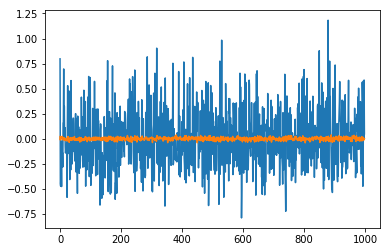

In [148]:
plt.plot(forecast['tas_gm_mo_'+str(mo)])
plt.plot(truth_state['tas_gm_mo_'+str(mo)])

In [145]:
for var in limvars: 
    print(var)
    print('GM CE = '+str(ce[var+'_gm_mo_'+str(mo)])+' GM Corr = '+ str(corr[var+'_gm_mo_'+str(mo)]))

tas
GM CE = -403.25880941645715 GM Corr = -0.024220206464738832
psl
GM CE = -741.4342540101476 GM Corr = -0.055287853100057884
tos
GM CE = -264.07100597064516 GM Corr = -0.03161414428771794
sit
GM CE = -342.94229872323535 GM Corr = -0.04336836101191847
sic
GM CE = -17.072935880843577 GM Corr = -0.019626058348466802


In [38]:
ce_ar1, corr_ar1= lim.calc_ce_corr_ar_lags(X_valid,X_train,lags,limvars,
                                           lat_2d[:,0],lon_2d[0,:])

working on tas
working on psl
working on tos
working on sic


In [39]:
ce_ar1_valid, corr_ar1_valid = lim.calc_ce_corr_ar_lags(X_valid,X_valid,lags,
                                                        limvars,lat_2d[:,0], lon_2d[0,:])

working on tas
working on psl
working on tos


/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:797: RuntimeWarning: invalid value encountered in true_divide
  lac = cov / std


working on sic


In [ ]:
X_valid.shape

In [ ]:
Xv.shape

In [112]:
v = 3
var = 'tos'
Xt = X_valid
Xv = X_valid
lat = lat_2d[:,0]
lon = lon_2d[0,:]
l = np.arange(1,2,1)

ar1_gm = np.zeros((len(l),Xv.shape[2]))
ar1_pm = np.zeros((len(l),2,Xv.shape[2]))
ce_pm = np.zeros((len(l),2))
corr_pm = np.zeros((len(l),2))

for i,lag in enumerate(l):
    ar1_forecast, ar1_factor = lim.red_noise_forecast_ar1(Xt[v,:].T,Xv[v,:].T,lead=lag)
    ar1_forecast_3d = np.reshape(ar1_forecast,(ar1_forecast.shape[0],nlat,nlon))
    X_valid_3d = np.reshape(Xv[v,:].T,(Xv.shape[2],nlat,nlon))
    ar1_gm[i,lag:],_,_ = LMR_utils.global_hemispheric_means(ar1_forecast_3d,lat)
    ar1_pm[i,:,lag:] = lim.polar_regional_means(ar1_forecast_3d,lat,lon)

    true_gm,_,_ = LMR_utils.global_hemispheric_means(X_valid_3d,lat)
    true_pm = lim.polar_regional_means(X_valid_3d,lat,lon)

    ce_gm = LMR_utils.coefficient_efficiency(true_gm[lag:],ar1_gm[i,lag:])
    corr_gm = np.corrcoef(true_gm[lag:],ar1_gm[i,lag:])[0,1]
    for n in range(2):
        ce_pm[i,n] = LMR_utils.coefficient_efficiency(true_pm[n,lag:],ar1_pm[i,n,lag:])
        corr_pm[i,n] = np.corrcoef(true_pm[n,lag:],ar1_pm[i,n,lag:])[0,1]

/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:793: RuntimeWarning: invalid value encountered in true_divide
  lac = cov / std


In [122]:
np.nanmin(ar1_factor), Xv[v,:].T.shape

(-0.00033366700033366306, (12000, 3240))

In [125]:
ar1_forecast.shape

(11999, 3240)

In [106]:
corr_gm

0.9848644683160668

In [110]:
np.corrcoef(true_gm[1:],ar1_gm[0,1:])[0,1]

0.9848644683160668

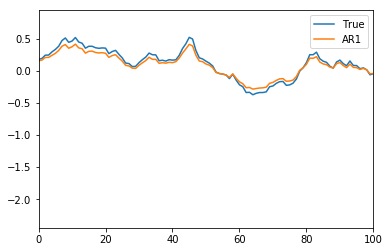

In [108]:
plt.plot(true_gm[1:], label='True')
plt.plot(ar1_gm[0,2:], label='AR1')
plt.xlim(0,100)
plt.legend()

#### check in eof space: 

In [ ]:
truth_eof = np.matmul(E_sic,x_valid_sic)
truth_eof_gm,_,_ = LMR_utils.global_hemispheric_means(np.reshape(truth_eof.T,(7212,45,72)), lat_2d[:,0])

In [ ]:
truth_state['sic_gm'].shape

In [ ]:
plt.plot(truth_state['sic_gm'][0,:],label='truth')
plt.plot(forecast['sic_gm'][0,:],label='forecast')
plt.plot(truth_eof_gm,label='truth eof')
plt.legend()
plt.title('GM SIC')

In [ ]:
k=0
ce_test = LMR_utils.coefficient_efficiency(truth_eof_gm,forecast[var+'_gm'][k,k:])
corr_test = np.corrcoef(truth_eof_gm,forecast[var+'_gm'][k,k:])[0,1]
corr_test, ce_test

In [148]:
corr_ar1_valid['tos_gm']

array([0.        , 0.98486447, 0.96391541, 0.93804171, 0.90800665,
       0.87682375, 0.84661718, 0.81847671, 0.79224612, 0.76764925,
       0.74339473, 0.71778917, 0.69008076])

In [ ]:
# load training data...
wt=True
var_dict = {}
tot_var = {}
tot_var_eig = {}
W_all = {}
standard_factor = {}
E3 = {}
Ptrunc = {}

# if sic_separate is True: 
#         E3 = np.zeros([X_allshape-X_sicshape,ntrunc*(nvars-1)])
# else:  
#     E3 = np.zeros([X_allshape,ntrunc*(nvars)])
n=0

for k, var in enumerate(limvars): 
    X_var, var_dict = load_data(var, var_dict, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    
    mo = 1
    tsamp = X_var.shape[1]
    nyears_train = int((tsamp*ntrain)/12)
    #nyears_valid = int(X_all_mpi.shape[2]/12)
    nyears_valid = int((tsamp*(1-ntrain))/12)

    X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
    X_train = X_t[:,0:nyears_train,mo]
    X_train2 = X_t[:,0:nyears_train,mo+1]
    X_valid = X_t[:,nyears_train:,mo]
    truth = X_t[:,nyears_train:,mo+1]
    ntime = X_train.shape[1]
     
    if (sic_separate is True) & (var is 'sic'):
            trunc = nmodes_sic
    else: 
        trunc = ntrunc
        
    if len(var_dict[var]['lat'].shape)<2:
        nlon = var_dict[var]['lon'].shape[0]
        nlat = var_dict[var]['lat'].shape[0]
        lat = var_dict[var]['lat'][:,np.newaxis]*np.ones((nlat,nlon))
    else: 
        lat = var_dict[var]['lat']

    [eofs_out, svals_out, pcs_out, 
     total_var, total_var_eig, 
     var_expl_by_retained, W] = limkb.eof_decomp_1var(X_train,lat,var_dict[var]['var_ndof'],
                                                      X_train.shape[1],trunc,Weight=wt)
    
    tot_var[var] = total_var
    tot_var_eig[var] = total_var_eig
    W_all[var] = np.squeeze(W)
    
    if k == 0:
        print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))
                                                                              
        # projection
        P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train))
        standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))

        Ptrunc[var] = P_var/standard_factor[var]

        # reverse operator from EOFs to grid point space
        E3[var] = eofs_out*standard_factor[var]
        n=n+1

    elif (sic_separate is True) & (var is 'sic'):
        print('fraction in first '+str(nmodes_sic)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))
        print('...separately')

        Pvar_sic = np.matmul(eofs_out.T,W*np.nan_to_num(X_train))
        standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))

        Ptrunc['sic'] = Pvar_sic/standard_factor[var]
        E['sic'] = eofs_out*standard_factor[var]

    else:
        print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))

        # projection
        P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train))
        standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))

        Ptrunc[var] = P_var/standard_factor[var]

        # reverse operator from EOFs to grid point space
        E3[var] = eofs_out*standard_factor[var]
        n=n+1

#             # projection
#             P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
#             standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))
            
#             Ptrunc = np.concatenate((Ptrunc,P_var/standard_factor[var]),axis=0)

#             # reverse operator from EOFs to grid point space
#             E3[var_dict[var]['var_inds'],n*ntrunc:(n+1)*ntrunc] = eofs_out*standard_factor[var]
#             n=n+1

    del X_var
    
# if k == 0: 
#     X_all = X_var
# else: 
#     X_all = np.concatenate((X_all,X_var),axis=0)